## Урок 2: Построение надежной локальной валидации

Задание на повторение:
Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных и получения гипотез для проведения валидации.
* Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.
* Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.
* Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.
* Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

Основное задание:
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

* Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

* Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

* Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

* Задание 4: выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

* Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

* Задание 6 * (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

* Задание 7 ** (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

In [697]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import catboost as catb
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import List, Tuple
from scipy.stats import probplot
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
warnings.simplefilter("ignore")
%matplotlib inline

### Загрузка данных

In [214]:
rs = 47 # random_state

In [215]:
test = pd.read_csv("assignment_test.csv")
test.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3062000,0,1643492,41.0,W,9500,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3062001,1,1643513,161.0,W,6668,390.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
train = pd.read_csv("assignment_train.csv")
train.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 50001 rows, 394 cols
test.shape = 75000 rows, 394 cols


In [218]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,49304.000000,49998.000000,49766.000000,47410.000000,47410.000000,...,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000,12268.000000
mean,3.012000e+06,0.027139,6.378101e+05,128.129726,9912.598368,366.635547,152.803612,200.704276,291.813162,85.590593,...,0.110450,38.942391,63.051814,45.816241,4.252527,14.926426,7.991718,15.742603,21.362671,16.464481
std,1.443419e+04,0.162491,3.229461e+05,213.078011,4904.597980,159.057800,10.482210,40.299048,104.991697,6.687334,...,0.469788,190.465893,446.405097,210.319262,46.694625,105.561868,60.584452,91.083819,131.071046,92.726771
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.999500e+06,0.000000,3.523050e+05,42.000000,6019.000000,208.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.012000e+06,0.000000,6.537500e+05,68.500000,9705.000000,369.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.024500e+06,0.000000,9.321340e+05,120.000000,14265.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.037000e+06,1.000000,1.189349e+06,4829.950000,18393.000000,600.000000,229.000000,237.000000,540.000000,102.000000,...,7.000000,6300.000000,32250.000000,6300.000000,1000.000000,2700.000000,1300.000000,1700.000000,3000.000000,1700.000000


In [219]:
target = "isFraud"

### Задание на повторение: Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных и получения гипотез для проведения валидации.

#### Задание 1: 
Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

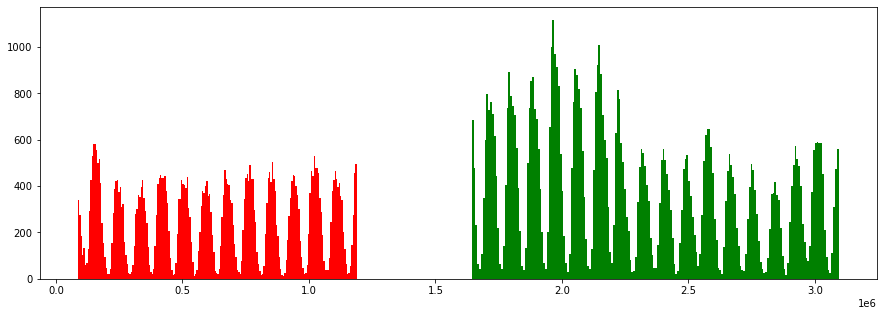

In [220]:
plt.figure(figsize=(15,5))
plt.hist(train['TransactionDT'], color='red', bins=200)
plt.hist(test['TransactionDT'], color='green', bins=200)
plt.show()

Трейн и тест разбиты по времени, причём отделены друг от друга с некоторым разрывом. Трейн имеет более ранние даты чем тест. На обеих выборках наблюдается сезонность.

#### Задание 2: 
Построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

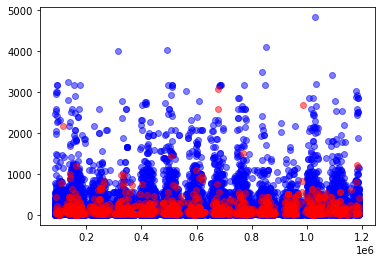

In [221]:
plt.scatter(train[train[target]==0]['TransactionDT'], train[train[target]==0]['TransactionAmt'], color='blue', alpha=0.5)
plt.scatter(train[train[target]==1]['TransactionDT'], train[train[target]==1]['TransactionAmt'], color='red', alpha=0.5)
plt.show()

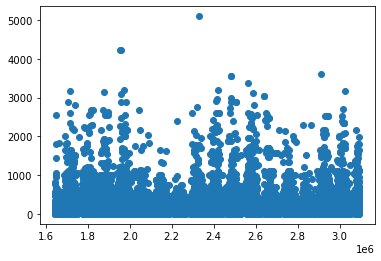

In [222]:
plt.scatter(test['TransactionDT'], test['TransactionAmt'])
plt.show()

Наборы данных тест и трейн довольно похожи друг на друга. На трейн выборке мошеннические операции сгруппированы и видимо совпадают со временем проведения обычных операций. Мошеннические операции проводятся небольшими суммами.

#### Задание 3: 
Построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

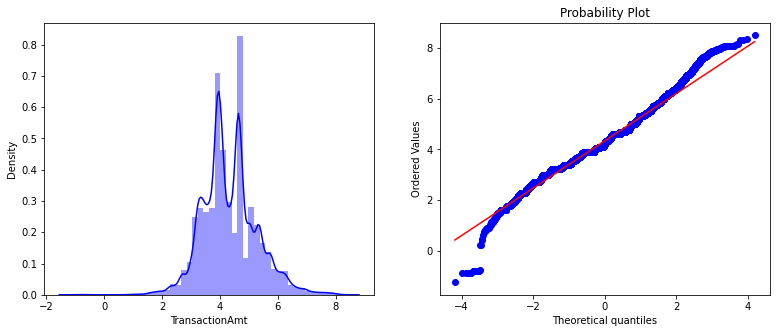

In [223]:
data = np.log(train['TransactionAmt'])
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(data, bins=50, color="blue")
plt.subplot(122)
probplot(data, plot=plt)
plt.show()

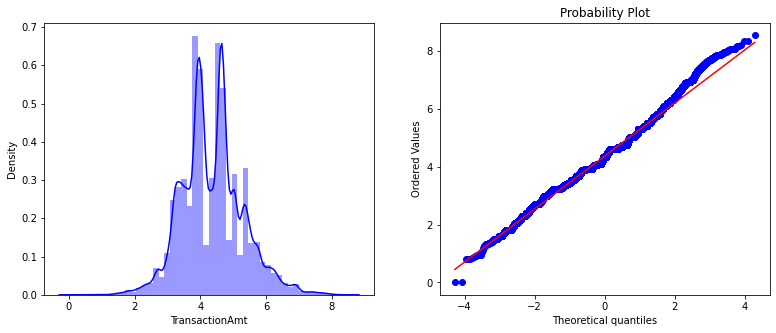

In [224]:
data = np.log(test['TransactionAmt'])
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(data, bins=50, color="blue")
plt.subplot(122)
probplot(data, plot=plt)
plt.show()

Распределения на трейн и тест похожи, но не являются нормальными.

#### Задание 4: 
Построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

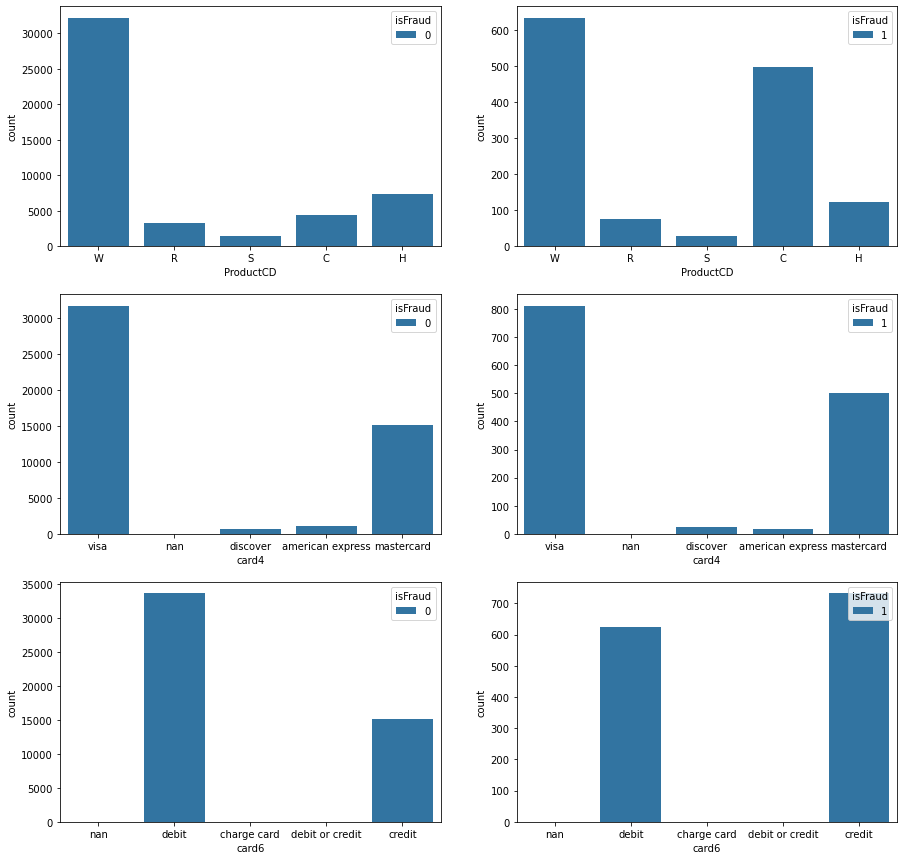

In [225]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for i, feature in enumerate(['ProductCD', 'card4', 'card6']):
    order = set(train[feature])
    sns.countplot(data=train[train[target]==0], x=feature, hue=target, ax=ax[i, 0], order=order)
    sns.countplot(data=train[train[target]==1], x=feature, hue=target, ax=ax[i, 1], order=order)
fig.show()

Распределения для обычных и мошеннических операций для ProductCD отличаются. В частности класс C имеет значительно больше мошеннических операций. Для card4 распределения похожи. Для card6 распределения отличаются: для кредитных карт мошеннических операций больше чем по дебетовым.

#### Задание 1: 
сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [226]:
cat_features = train.select_dtypes("object").columns.tolist()
drop_features = [target, 'TransactionID', 'TransactionDT']

In [227]:
train[cat_features] = train[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)

In [228]:
x_train, x_valid = train_test_split(train.drop(drop_features, axis=1), train_size=0.7, shuffle=True, random_state=rs)
y_train, y_valid = train_test_split(train[target], train_size=0.7, shuffle=True, random_state=rs)
x_public = test.drop(drop_features, axis=1)
y_public = test[target]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_public.shape = {} rows, {} cols".format(*x_public.shape))

x_train.shape = 35000 rows, 391 cols
x_valid.shape = 15001 rows, 391 cols
x_public.shape = 75000 rows, 391 cols


100%|██████████| 8/8 [00:27<00:00,  3.49s/it]


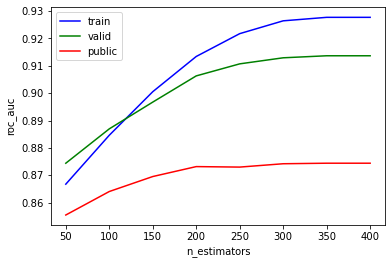

[0.8555000159656743, 0.8640825215668713, 0.8695549918254624, 0.873185007815872, 0.8730059491250417, 0.8742277096981689, 0.8744240692208672, 0.8744240692208672]
CPU times: user 5min 46s, sys: 15.7 s, total: 6min 2s
Wall time: 28 s


In [229]:
%%time
train_score = []
valid_score = []
public_score = []
eval_set = [(x_valid, y_valid)]
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400]

for e in tqdm(n_estimators):
    model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=e,
                                    max_depth=4, early_stopping_rounds=10, learning_rate=0.1,
                                    silent=True, random_state=rs)
    model.fit(x_train, y_train, eval_set=eval_set)
    train_score.append(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
    valid_score.append(roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1]))
    public_score.append(roc_auc_score(y_public, model.predict_proba(x_public)[:, 1]))
    
plt.plot(n_estimators, train_score, label='train', color='blue')
plt.plot(n_estimators, valid_score, label='valid', color='green')
plt.plot(n_estimators, public_score, label='public', color='red')
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

print(public_score)

Видно, что разница в метрике roc_auc между train, valid и test очень большая.

#### Задание 2: 
Сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [230]:
x_train, x_valid = train_test_split(train.drop(drop_features, axis=1), train_size=0.7, shuffle=True, random_state=rs)
y_train, y_valid = train_test_split(train[target], train_size=0.7, shuffle=True, random_state=rs)
x_valid, x_test = train_test_split(x_valid, train_size=0.5, random_state=rs, shuffle=True)
y_valid, y_test = train_test_split(y_valid, train_size=0.5, random_state=rs, shuffle=True)
x_public = test.drop(drop_features, axis=1)
y_public = test[target]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
print("x_public.shape = {} rows, {} cols".format(*x_public.shape))

x_train.shape = 35000 rows, 391 cols
x_valid.shape = 7500 rows, 391 cols
x_test.shape = 7501 rows, 391 cols
x_public.shape = 75000 rows, 391 cols


100%|██████████| 8/8 [00:25<00:00,  3.21s/it]


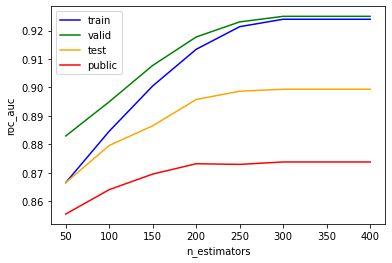

[0.8555115791333585, 0.8640825215668713, 0.8695549918254624, 0.873185007815872, 0.8729515098299645, 0.8738020192867593, 0.8738020192867593, 0.8738020192867593]
CPU times: user 5min 15s, sys: 13.6 s, total: 5min 28s
Wall time: 25.8 s


In [231]:
%%time
train_score = []
valid_score = []
test_score = []
public_score = []
eval_set = [(x_valid, y_valid)]
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400]

for e in tqdm(n_estimators):
    model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=e,
                                    max_depth=4, early_stopping_rounds=10, learning_rate=0.1,
                                    silent=True, random_state=rs)
    model.fit(x_train, y_train, eval_set=eval_set)
    train_score.append(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
    valid_score.append(roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1]))
    test_score.append(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))
    public_score.append(roc_auc_score(y_public, model.predict_proba(x_public)[:, 1]))
    
plt.plot(n_estimators, train_score, label='train', color='blue')
plt.plot(n_estimators, valid_score, label='valid', color='green')
plt.plot(n_estimators, test_score, label='test', color='orange')
plt.plot(n_estimators, public_score, label='public', color='red')
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

print(public_score)

Ситуация с расхождением метрик на разных выборках немного улучшилась, графики стали чуть ближе друг к другу. Но само значение метрики практически не изменилось.

#### Задание 3: 
Построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

На основе п.2. возьмём число деревьев, соответствующее максимальному значению метрики, при котором переобучение ещё не сильно наблюдается, т.е. 200

In [239]:
model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=200, 
                                max_depth=4, early_stopping_rounds=10, learning_rate=0.1,
                                silent=True, random_state=rs)
model.fit(x_train, y_train, eval_set=eval_set)

In [240]:
print(roc_auc_score(y_public, model.predict_proba(x_public)[:, 1]))

0.873185007815872


In [241]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [242]:
np.random.seed(1)
scores = create_bootstrap_metrics(y_test, model.predict_proba(x_test)[:, 1], roc_auc_score)
calculate_confidence_interval(scores)

(0.8693573726047599, 0.9194794543718229)

Доверительный интервал получился довольно широким, но значение метрики на публичном борде всё же попало в доверительный интервал.

#### Задание 4: 
Выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [669]:
X_adv = pd.concat([train, test])
y_adv = np.hstack((np.ones(train.shape[0]), np.zeros(test.shape[0])))
X_adv = X_adv.reset_index(drop=True)
X_adv = X_adv.drop(drop_features, axis=1)

Для обучения отделения теста от трейна применим простую модель с глубиной 3, но с числом деревьев 500.

In [670]:
%%time
model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=500, 
                                max_depth=3, early_stopping_rounds=10, learning_rate=0.1, 
                                silent=True, random_state=rs)
model.fit(X_adv, y_adv)

CPU times: user 3min 35s, sys: 6.37 s, total: 3min 41s
Wall time: 15.2 s


In [671]:
y_pred_4 = model.predict_proba(train.drop(drop_features, axis=1))[:, 1]

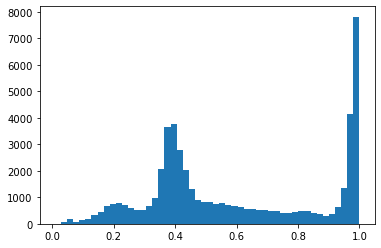

In [672]:
plt.hist(y_pred_4, bins=50)
plt.show()

Чтобы обучающая выборка была не слишком маленькая, возьмём порог в 0.3.

In [673]:
mask = y_pred_4 > 0.3
x_train, x_valid = train_test_split(train.loc[mask].drop(drop_features, axis=1), train_size=0.7, shuffle=True, 
                                    random_state=rs)
y_train, y_valid = train_test_split(train.loc[mask][target], train_size=0.7, shuffle=True, random_state=rs)
x_valid, x_test = train_test_split(x_valid, train_size=0.5, random_state=rs, shuffle=True)
y_valid, y_test = train_test_split(y_valid, train_size=0.5, random_state=rs, shuffle=True)
x_public = test.drop(drop_features, axis=1)
y_public = test[target]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
print("x_public.shape = {} rows, {} cols".format(*x_public.shape))

x_train.shape = 30945 rows, 391 cols
x_valid.shape = 6631 rows, 391 cols
x_test.shape = 6632 rows, 391 cols
x_public.shape = 75000 rows, 391 cols


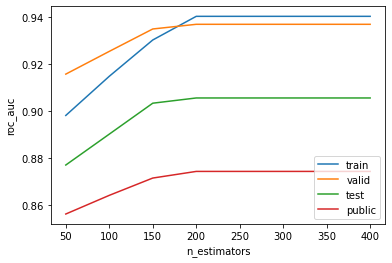

[0.8561910584128928, 0.8641284755839305, 0.8714859740708456, 0.8743110762371064, 0.8743110762371064, 0.8743110762371064, 0.8743110762371064, 0.8743110762371064]
CPU times: user 6min 58s, sys: 14.6 s, total: 7min 12s
Wall time: 32.4 s


In [674]:
%%time
train_score = []
valid_score = []
test_score = []
public_score = []
eval_set = [(x_valid, y_valid)]
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400]

for e in n_estimators:
    model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=e,
                                    max_depth=7, early_stopping_rounds=10, learning_rate=0.1,
                                    silent=True, random_state=rs)
    model.fit(x_train, y_train, eval_set=eval_set)
    train_score.append(roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]))
    valid_score.append(roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1]))
    test_score.append(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))
    public_score.append(roc_auc_score(y_public, model.predict_proba(x_public)[:, 1]))
    
plt.plot(n_estimators, train_score, label='train')
plt.plot(n_estimators, valid_score, label='valid')
plt.plot(n_estimators, test_score, label='test')
plt.plot(n_estimators, public_score, label='public')
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

print(public_score)

Возьмём число деревьев, при котором метрика максимальна, т.е. 200

In [675]:
model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=200,
                                max_depth=7, early_stopping_rounds=10, learning_rate=0.1,
                                silent=True, random_state=rs)
model.fit(x_train, y_train, eval_set=eval_set)
print(roc_auc_score(y_public, model.predict_proba(x_public)[:, 1]))

0.8743110762371064


In [676]:
np.random.seed(1)
scores = create_bootstrap_metrics(y_test, model.predict_proba(x_test)[:, 1], roc_auc_score)
calculate_confidence_interval(scores)

(0.8742064517609345, 0.9334870880219798)

Значение метрики в 0.8743110762371064 входит в доверительный интервал, пусть и почти на грани. Значение получилось чуть лучше чем в предыдущих пунктах

#### Задание 5:
Сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

In [707]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          X_test: pd.DataFrame,
                          y_test: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores, fold_test_scores = [], [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict_proba(x_train)[:, 1]
        y_valid_pred = estimator.predict_proba(x_valid)[:, 1]
        y_test_pred = estimator.predict_proba(X_test)[:, 1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        fold_test_scores.append(metric(y_test, y_test_pred))
        oof_predictions[valid_idx] = y_valid_pred
        left_bound, right_bound = calculate_confidence_interval(create_bootstrap_metrics(y_test, 
                                                                                         y_test_pred, metric))
        
        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}, " 
            f"test-score = {round(fold_test_scores[fold_number], 4)}, " 
            f"confidence_interval = {round(left_bound, 4), round(right_bound, 4)}"
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"CV-results test: {round(np.mean(fold_test_scores), 4)} +/- {round(np.std(fold_test_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, fold_test_scores, oof_predictions

In [708]:
model = catb.CatBoostClassifier(cat_features=cat_features, eval_metric='AUC', n_estimators=200, 
                                max_depth=4, early_stopping_rounds=10, learning_rate=0.1,
                                silent=True, random_state=rs)

In [709]:
cv_strategy = KFold(n_splits=5, random_state=rs)

estimators, oof_score, fold_train_scores, fold_valid_scores, fold_test_scores, oof_predictions = \
make_cross_validation(
    train.drop(drop_features, axis=1), train[target], 
    test.drop(drop_features, axis=1), test[target],
    model, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 40000, valid-observations = 10001
train-score = 0.9204, valid-score = 0.8432, test-score = 0.8686, confidence_interval = (0.8581, 0.8789)
Fold: 2, train-observations = 40001, valid-observations = 10000
train-score = 0.9165, valid-score = 0.8796, test-score = 0.8708, confidence_interval = (0.861, 0.88)
Fold: 3, train-observations = 40001, valid-observations = 10000
train-score = 0.9115, valid-score = 0.9002, test-score = 0.873, confidence_interval = (0.8628, 0.8824)
Fold: 4, train-observations = 40001, valid-observations = 10000
train-score = 0.9149, valid-score = 0.8849, test-score = 0.8742, confidence_interval = (0.8643, 0.884)
Fold: 5, train-observations = 40001, valid-observations = 10000
train-score = 0.9116, valid-score = 0.9045, test-score = 0.8756, confidence_interval = (0.8659, 0.885)
CV-results train: 0.915 +/- 0.003
CV-results valid: 0.8825 +/- 0.022
CV-results test: 0.8724 +/- 0.002
OOF-score = 0.8813


Значение метрики на отложенной выборке получилась равной 0.8724 +/- 0.002. Стандартное отклонение составило меньше процента, что говорит об устойчивости модели. Все метрики отложенной выборки попали в доверительный интервал.

#### Задание 6 * (опциональное): 
Сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на тестовой выборке с полученным доверительным интервалом. Сделать выводы.

In [710]:
estimators, oof_score, fold_train_scores, fold_valid_scores, fold_test_scores, oof_predictions = \
make_cross_validation(
    train.drop(drop_features, axis=1), train[target], 
    test.drop(drop_features, axis=1), test[target],
    model, metric=roc_auc_score, cv_strategy=TimeSeriesSplit(n_splits=5)
)

Fold: 1, train-observations = 8336, valid-observations = 8333
train-score = 0.9344, valid-score = 0.8605, test-score = 0.8386, confidence_interval = (0.8281, 0.849)
Fold: 2, train-observations = 16669, valid-observations = 8333
train-score = 0.9269, valid-score = 0.8785, test-score = 0.8643, confidence_interval = (0.854, 0.874)
Fold: 3, train-observations = 25002, valid-observations = 8333
train-score = 0.9198, valid-score = 0.8812, test-score = 0.8678, confidence_interval = (0.8582, 0.8771)
Fold: 4, train-observations = 33335, valid-observations = 8333
train-score = 0.9127, valid-score = 0.898, test-score = 0.8731, confidence_interval = (0.8637, 0.8829)
Fold: 5, train-observations = 41668, valid-observations = 8333
train-score = 0.9127, valid-score = 0.8985, test-score = 0.8782, confidence_interval = (0.8688, 0.8867)
CV-results train: 0.9213 +/- 0.008
CV-results valid: 0.8833 +/- 0.014
CV-results test: 0.8644 +/- 0.014
OOF-score = 0.7758


Значение метрики на отложенной выборке получилась равной 0.8644 +/- 0.014, т.е. с большим разбросом нежели в п.5.
Стандартное отклонение составило меньше двух процентов. Все метрики отложенной выборки попали в доверительный интервал.